In [ ]:
import elecboltz
# IMPORTANT: this example depends on the cuprates_transport package
# https://github.com/gaelgrissonnanche/cuprates_transport
from cuprates_transport.bandstructure import BandStructure
from cuprates_transport.conductivity import Conductivity

from scipy.constants import e
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [17]:
# matplotlib settings
# reset defaults
mpl.rcdefaults()
# font
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
# plotting
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 20

In [18]:
params_chambers = {
    'band_name': "Nd-LSCO",
    'a': 3.75,
    'b': 3.75,
    'c': 13.2,
    'energy_scale': 160,
    'band_params':{'mu': -0.8243, 't': 1, 'tp':-0.1364,
                   'tpp': 0.0682, 'tz': 0.0651},
    'scattering_models':['isotropic', 'cos2phi'],
    'scattering_params':{'gamma_0': 12.595, 'gamma_k': 63.823, 'power': 12.0},
    'resolution': [61, 61, 61],
    'N_time': 3000,
    'rtol': 1e-8,
    'atol': 1e-8,
    'k_max': [np.pi, np.pi, 2*np.pi]
}

In [19]:
params_fem = params_chambers.copy()
params_fem['resolution'] = 41
params_fem['domain_size'] = [1.0, 1.0, 2.0]
params_fem['periodic'] = 2
params_fem = elecboltz.easy_params(params_fem)

In [20]:
fields = np.linspace(0, 100, 100)

In [21]:
band_chambers = BandStructure(**params_chambers)
band_chambers.runBandStructure()
rho_chambers_zz = np.empty_like(fields)
for i, field in enumerate(fields):
    params_chambers['Bamp'] = field
    cond_chambers = Conductivity(band_chambers, **params_chambers)
    cond_chambers.runTransport()
    rho_chambers = np.linalg.inv(cond_chambers.sigma)
    rho_chambers_zz[i] = rho_chambers[2, 2]

In [22]:
band_fem = elecboltz.BandStructure(**params_fem)
band_fem.discretize()
rho_fem_zz = np.empty_like(fields)
cond_fem = elecboltz.Conductivity(band_fem, **params_fem)
for i, field in enumerate(fields):
    cond_fem.field = [0, 0, field]
    cond_fem.calculate()
    rho_fem = np.linalg.inv(cond_fem.sigma)
    rho_fem_zz[i] = rho_fem[2, 2]

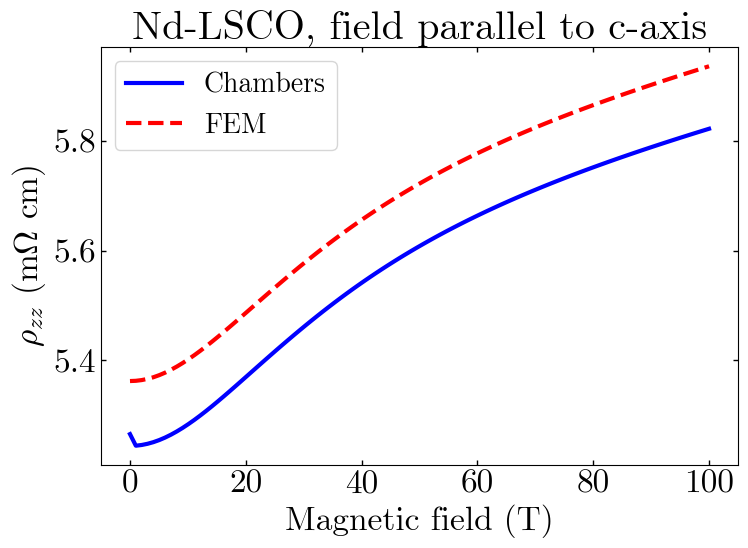

In [23]:
plt.plot(fields, 1e5 * rho_chambers_zz, label="Chambers", color='blue')
plt.plot(fields, 1e5 * rho_fem_zz, label="FEM", color='red', linestyle='--')
plt.xlabel("Magnetic field (T)")
plt.ylabel(r"$\rho_{zz}$ (m$\Omega$ cm)")
plt.title("Nd-LSCO, field parallel to c-axis")
plt.legend()
plt.tight_layout()
plt.savefig("NdLSCO/rhozz_Bmag_FEM_vs_Chambers.pdf", bbox_inches='tight')
plt.show()

In [24]:
params_chambers = {
    'band_name': "Nd-LSCO",
    'a': 3.75,
    'b': 3.75,
    'c': 13.2,
    'energy_scale': 160,
    'band_params':{'mu':-0.8243, 't': 1, 'tp':-0.1364,
                   'tpp':0.0682, 'tz':0.0651},
    'scattering_models':['isotropic'],
    'scattering_params':{'gamma_0': 1.0},
    'resolution': [41, 41, 41],
    'N_time': 15000,
    'rtol': 1e-8,
    'atol': 1e-8,
    'k_max': [np.pi, np.pi, 2*np.pi]
}

In [ ]:
params_fem = params_chambers.copy()
params_fem['resolution'] = 41
params_fem['domain_size'] = [1.0, 1.0, 2.0]
params_fem['periodic'] = 2
params_fem = elecboltz.easy_params(params_fem)

In [32]:
fields = np.logspace(1, 4, 100)
n = band_fem.calculate_electron_density(depth=8)
rh_inf = -1 / n / e

In [27]:
band_chambers = BandStructure(**params_chambers)
band_chambers.runBandStructure()
rh_chambers = np.empty_like(fields)
for i, field in enumerate(fields):
    params_chambers['Bamp'] = field
    cond_chambers = Conductivity(band_chambers, **params_chambers)
    cond_chambers.runTransport()
    rh_chambers[i] = cond_chambers.sigma[0, 1] / field / (
        cond_chambers.sigma[0, 0]**2 + cond_chambers.sigma[0, 1]**2)

In [34]:
band_fem = elecboltz.BandStructure(**params_fem)
band_fem.discretize()
rh_fem = np.empty_like(fields)
cond_fem = elecboltz.Conductivity(band_fem, **params_fem)
for i, field in enumerate(fields):
    cond_fem.field = [0, 0, field]
    cond_fem.calculate()
    rh_fem[i] = cond_fem.sigma[0, 1] / field / (
        cond_fem.sigma[0, 0]**2 + cond_fem.sigma[0, 1]**2)

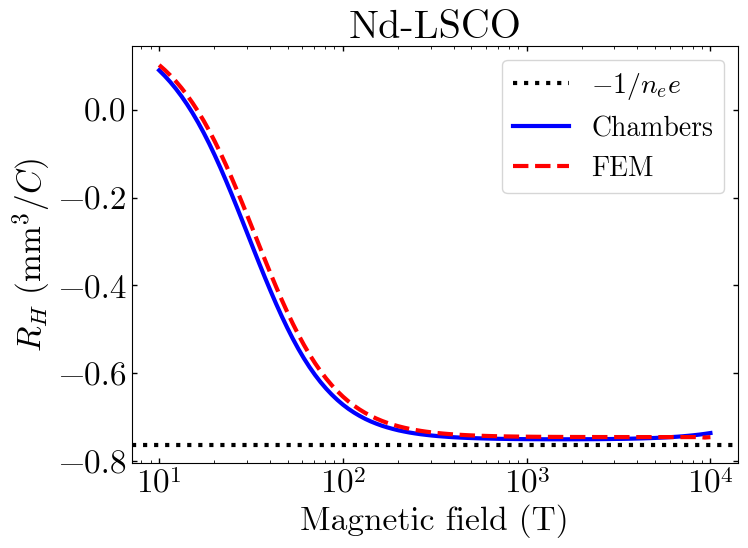

In [35]:
plt.axhline(1e9 * rh_inf, color='black', linestyle=':', label=r"$-1/n_ee$")
plt.semilogx(fields, 1e9 * rh_chambers, label="Chambers", color='blue')
plt.semilogx(fields, 1e9 * rh_fem, label="FEM", color='red', linestyle='--')
plt.xlabel("Magnetic field (T)")
plt.ylabel(r"$R_H$ ($\mathrm{mm}^3/C$)")
plt.title("Nd-LSCO")
plt.legend()
plt.tight_layout()
plt.savefig("NdLSCO/rh_fem_vs_chambers_high_field_isotropic.pdf", bbox_inches='tight')
plt.show()